In [6]:
HOME_DIR = '/Users/yoav/Documents/Yoav/CS/20936 - DS Project/Shotpred'
DATA_DIR = os.path.join(HOME_DIR, 'data')
EXT_DATA_DIR = os.path.join(DATA_DIR, 'External')
INT_DATA_DIR = os.path.join(DATA_DIR, 'Internal')

In [ ]:
import pandas as pd
import os
from nba_api.stats.endpoints import playerindex, playbyplayv3
import sys
sys.path.append(HOME_DIR)
import data_utils as du

import importlib
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

In [8]:
KAGGLE_SHOT_LOGS_201415_FILENAME = 'kaggle_shot_logs_2014_15.csv'
KAGGLE_SHOT_LOGS_201415_FULLPATH = os.path.join(EXT_DATA_DIR, KAGGLE_SHOT_LOGS_201415_FILENAME)

GENERAL_SHOT_LOGS_FILENAME = 'nba_2015_shots.csv'
GENERAL_SHOT_LOGS_FULLPATH = os.path.join(EXT_DATA_DIR, GENERAL_SHOT_LOGS_FILENAME)

In [9]:
KAGGLE_COLS_FOR_MERGE = ['GAME_ID', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'player_id', 'absolute_game_time']
CAREER_STATS_COL_FOR_MERGE = ['PLAYER_ID', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT'] #already filtered for relevant season

In [10]:
shot_logs_1415 = pd.read_csv(KAGGLE_SHOT_LOGS_201415_FULLPATH)

In [11]:
active_players_201415_ids = shot_logs_1415['player_id'].unique()

In [12]:
shot_logs_1415['absolute_game_time'] = shot_logs_1415.apply(lambda row: du.clock_to_absolute_seconds(row['GAME_CLOCK'], row['PERIOD']), axis=1)

In [8]:
#active_players_career_stats = du.gather_mul_career_stats(active_players_201415_ids) # get the career stats for all active players in 2014-15 season

In [9]:
#active_players_cs_in_1415 = active_players_career_stats[active_players_career_stats['SEASON_ID'] == '2014-15'].reset_index(drop=True)
#active_players_cs_in_1415.to_csv(INT_DATA_DIR + 'active_players_career_stats_2014_15.csv', index=False)

In [13]:
active_players_cs_in_1415 = pd.read_csv(os.path.join(INT_DATA_DIR, 'active_players_career_stats_2014_15.csv'))

In [14]:
gen_sl = pd.read_csv(GENERAL_SHOT_LOGS_FULLPATH)

In [15]:
gen_sl['absolute_game_time'] = gen_sl.apply(lambda row: du.clock_to_absolute_seconds(f"{str(row["MINS_LEFT"]).zfill(2)}:{str(row["SECS_LEFT"]).zfill(2)}", row['QUARTER']), axis=1)

In [16]:
kaggle_for_join = shot_logs_1415[KAGGLE_COLS_FOR_MERGE]

In [17]:
kaggle_for_join.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time
0,21400899,10.8,2,1.9,"Anderson, Alan",101187,1.3,203148,651.0
1,21400899,3.4,0,0.8,"Bogdanovic, Bojan",202711,6.1,203148,706.0
2,21400899,NaN,3,2.7,"Bogdanovic, Bojan",202711,0.9,203148,720.0
3,21400899,10.3,2,1.9,"Brown, Markel",203900,3.4,203148,733.0
4,21400899,10.9,2,2.7,"Young, Thaddeus",201152,1.1,203148,806.0


In [18]:
gen_sl_game_ids = set(gen_sl['GAME_ID'].unique())
kaggle_for_join_game_ids = set(kaggle_for_join['GAME_ID'].unique())

common_game_ids = gen_sl_game_ids.intersection(kaggle_for_join_game_ids)

print(f"Number of unique GAME_IDs in gen_sl: {len(gen_sl_game_ids)}")
print(f"Number of unique GAME_IDs in kaggle_for_join: {len(kaggle_for_join_game_ids)}")
print(f"Number of common GAME_IDs in both: {len(common_game_ids)}")

Number of unique GAME_IDs in gen_sl: 1230
Number of unique GAME_IDs in kaggle_for_join: 904
Number of common GAME_IDs in both: 904


In [21]:
kaggle_for_join = kaggle_for_join.sort_values(by=['absolute_game_time']).reset_index(drop=True)

In [22]:
gen_sl = gen_sl.sort_values(by=['absolute_game_time']).reset_index(drop=True)
gen_sl['gen_sl_time_copy'] = gen_sl['absolute_game_time']

In [23]:
merged = pd.merge_asof(kaggle_for_join, gen_sl, on='absolute_game_time',left_by=['player_id', 'GAME_ID'], right_by=['PLAYER_ID', 'GAME_ID'],  direction='nearest', suffixes=['_kaggle', '_shot_logs'], tolerance=5) #,left_by=['player_id', 'GAME_ID'], right_by=['PLAYER_ID', 'GAME_ID'], 

In [50]:
merged

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,Center,C,Less Than 8 ft.,-0.6,5.35,0.0,1.0,11.0,54.0,6.0
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,Center,C,Less Than 8 ft.,1.5,6.45,1.0,1.0,11.0,51.0,9.0
2,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,Center,C,Less Than 8 ft.,-0.0,5.35,0.0,1.0,11.0,55.0,5.0
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,Center,C,Less Than 8 ft.,-2.2,6.65,2.0,1.0,11.0,54.0,6.0
4,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,Center,C,Less Than 8 ft.,-2.4,5.05,2.0,1.0,11.0,52.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400164,8.0,0,0.8,"Ilyasova, Ersan",101141,6.6,202711,5018.0,2015.0,...,Left Side Center,LC,24+ ft.,11.1,26.95,24.0,7.0,0.0,19.0,5021.0
128065,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,2015.0,...,Left Side,L,16-24 ft.,19.4,11.65,20.0,7.0,0.0,17.0,5023.0
128066,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,2015.0,...,Right Side,R,16-24 ft.,-16.6,4.95,16.0,7.0,0.0,7.0,5033.0
128067,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,2015.0,...,Right Side Center,RC,24+ ft.,-13.3,29.35,27.0,7.0,0.0,3.0,5037.0


In [25]:
not_merged = merged[merged.gen_sl_time_copy.isna()]

In [26]:
not_merged.head()

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy
145,21400345,11.6,2,5.0,"Conley, Mike",201144,0.3,203487,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
158,21400471,22.9,0,2.1,"Hill, Jordan",201941,2.6,202389,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
230,21400872,11.2,0,0.0,"Amundson, Lou",200811,3.7,202685,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,21400322,10.9,0,4.6,"Joseph, Cory",202709,2.9,101181,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
388,21400515,9.6,5,4.1,"Holiday, Jrue",201950,5.7,202322,16.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
heights = pd.read_csv(os.path.join(INT_DATA_DIR, 'nba_2014_2015_player_heights.csv'))

In [30]:
heights

,PLAYER_NAME,HEIGHT
0,AJ Price,6-2
1,Aaron Brooks,6-0
2,Aaron Gordon,6-8
3,Adreian Payne,6-10
4,Al Horford,6-9
...,...,...
487,Xavier Henry,6-6
488,Zach LaVine,6-5
489,Zach Randolph,6-9
490,Zaza Pachulia,6-11


In [52]:
merged

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_NAME,ZONE_ABB,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,Center,C,Less Than 8 ft.,-0.6,5.35,0.0,1.0,11.0,54.0,6.0
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,Center,C,Less Than 8 ft.,1.5,6.45,1.0,1.0,11.0,51.0,9.0
2,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,Center,C,Less Than 8 ft.,-0.0,5.35,0.0,1.0,11.0,55.0,5.0
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,Center,C,Less Than 8 ft.,-2.2,6.65,2.0,1.0,11.0,54.0,6.0
4,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,Center,C,Less Than 8 ft.,-2.4,5.05,2.0,1.0,11.0,52.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128064,21400164,8.0,0,0.8,"Ilyasova, Ersan",101141,6.6,202711,5018.0,2015.0,...,Left Side Center,LC,24+ ft.,11.1,26.95,24.0,7.0,0.0,19.0,5021.0
128065,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,2015.0,...,Left Side,L,16-24 ft.,19.4,11.65,20.0,7.0,0.0,17.0,5023.0
128066,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,2015.0,...,Right Side,R,16-24 ft.,-16.6,4.95,16.0,7.0,0.0,7.0,5033.0
128067,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,2015.0,...,Right Side Center,RC,24+ ft.,-13.3,29.35,27.0,7.0,0.0,3.0,5037.0


In [ ]:
# Merge for attacker heights
merged_with_attacker_heights = pd.merge(merged, heights, left_on='PLAYER_NAME', right_on='PLAYER_NAME', suffixes=('', '_attacker'))

# !!!!!!Merge for defender heights - CAUSES NULL VALUES BECAUSE OF THE DIFFERENT PLAYER NAMES AND LEFT JOIN - NEED IDS!!!!!
merged_with_both_heights = pd.merge(merged_with_attacker_heights, heights, left_on='CLOSEST_DEFENDER', right_on='PLAYER_NAME', suffixes=('_attacker', '_defender'), how='left')

# Drop the extra PLAYER_NAME column from the second merge
merged_with_both_heights = merged_with_both_heights.drop(columns=['PLAYER_NAME_defender'])

merged_with_both_heights

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,ZONE_RANGE,LOC_X,LOC_Y,SHOT_DISTANCE,QUARTER,MINS_LEFT,SECS_LEFT,gen_sl_time_copy,HEIGHT_attacker,HEIGHT_defender
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,Less Than 8 ft.,-0.6,5.35,0.0,1.0,11.0,54.0,6.0,6-4,NaN
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,Less Than 8 ft.,1.5,6.45,1.0,1.0,11.0,51.0,9.0,6-9,NaN
2,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,Less Than 8 ft.,-0.0,5.35,0.0,1.0,11.0,55.0,5.0,6-9,NaN
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,Less Than 8 ft.,-2.2,6.65,2.0,1.0,11.0,54.0,6.0,6-3,NaN
4,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,Less Than 8 ft.,-2.4,5.05,2.0,1.0,11.0,52.0,8.0,6-8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124542,21400375,6.3,17,17.7,"Duncan, Tim",1495,5.0,201144,5017.0,2015.0,...,16-24 ft.,2.4,22.85,17.0,7.0,0.0,20.0,5020.0,6-0,NaN
124543,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,2015.0,...,16-24 ft.,19.4,11.65,20.0,7.0,0.0,17.0,5023.0,6-5,NaN
124544,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,2015.0,...,16-24 ft.,-16.6,4.95,16.0,7.0,0.0,7.0,5033.0,6-7,NaN
124545,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,2015.0,...,24+ ft.,-13.3,29.35,27.0,7.0,0.0,3.0,5037.0,6-6,NaN


In [55]:
heights.head()

,PLAYER_NAME,HEIGHT
0,AJ Price,6-2
1,Aaron Brooks,6-0
2,Aaron Gordon,6-8
3,Adreian Payne,6-10
4,Al Horford,6-9


In [56]:
COLS_FOR_PRED = ['SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'absolute_game_time', 'SEASON_1', 'SEASON_2', 'TEAM_ID', 'PLAYER_ID', 'POSITION_GROUP', 'POSITION', 'GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM', 'EVENT_TYPE', 'SHOT_MADE', 'ACTION_TYPE', 'SHOT_TYPE', 'BASIC_ZONE', 'ZONE_NAME', 'ZONE_ABB', 'ZONE_RANGE', 'LOC_X', 'LOC_Y', 'SHOT_DISTANCE', 'QUARTER', 'MINS_LEFT', 'SECS_LEFT', 'HEIGHT_attacker', 'HEIGHT_defender']
COLS_FOR_PRED.extend(CAREER_STATS_COL_FOR_MERGE)

# interchange SEASON1/SEASON2
# maybe the game date is highly correlated with season so leave only game date
# probably need to chose only subset of the game time/qtr/mins_left/secs_left features
# SHOT_MADE and EVENT_TYPE is g.t

In [57]:
cs_for_merge = active_players_cs_in_1415[CAREER_STATS_COL_FOR_MERGE]
for_pred = pd.merge(merged_with_both_heights, cs_for_merge, on='PLAYER_ID')

In [58]:
for_pred[COLS_FOR_PRED]

,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,absolute_game_time,SEASON_1,SEASON_2,TEAM_ID,PLAYER_ID,...,PLAYER_ID,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
0,22.0,2,1.8,202709,2.3,3.0,2015.0,2014-15,1.610613e+09,2754.0,...,2754.0,225,455,0.495,10,29,0.345,79,126,0.627
1,21.8,3,3.2,201565,5.3,4.0,2015.0,2014-15,1.610613e+09,202693.0,...,202693.0,512,1100,0.465,57,179,0.318,177,232,0.763
2,20.6,0,0.0,201586,4.0,4.0,2015.0,2014-15,1.610613e+09,202693.0,...,202693.0,512,1100,0.465,57,179,0.318,177,232,0.763
3,21.1,0,1.3,203095,3.4,4.0,2015.0,2014-15,1.610613e+09,203463.0,...,203463.0,363,831,0.437,140,391,0.358,130,160,0.813
4,22.5,2,2.5,201960,3.5,4.0,2015.0,2014-15,1.610613e+09,2772.0,...,2772.0,366,910,0.402,194,555,0.350,122,143,0.853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148222,6.3,17,17.7,1495,5.0,5017.0,2015.0,2014-15,1.610613e+09,201144.0,...,201144.0,393,882,0.446,107,277,0.386,214,249,0.859
148223,0.7,1,2.1,1495,9.8,5023.0,2015.0,2014-15,1.610613e+09,201584.0,...,201584.0,288,643,0.448,90,224,0.402,111,129,0.860
148224,NaN,0,0.8,203507,3.9,5030.0,2015.0,2014-15,1.610613e+09,2207.0,...,2207.0,446,1025,0.435,121,337,0.359,141,176,0.801
148225,NaN,9,6.4,201188,5.1,5035.0,2015.0,2014-15,1.610613e+09,1938.0,...,1938.0,251,589,0.426,89,258,0.345,147,204,0.721


In [59]:
def visualize_distributions(df):
    """
    Create visualizations for data distributions
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    numerical_cols = numerical_cols.drop(['PLAYER_ID', 'CLOSEST_DEFENDER_PLAYER_ID', 'SEASON_1'])
    
    # Distribution plots for numerical columns
    plt.figure(figsize=(15, 5 * (len(numerical_cols) // 3 + 1)))
    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(len(numerical_cols) // 3 + 1, 3, i)
        sns.histplot(df[col], kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

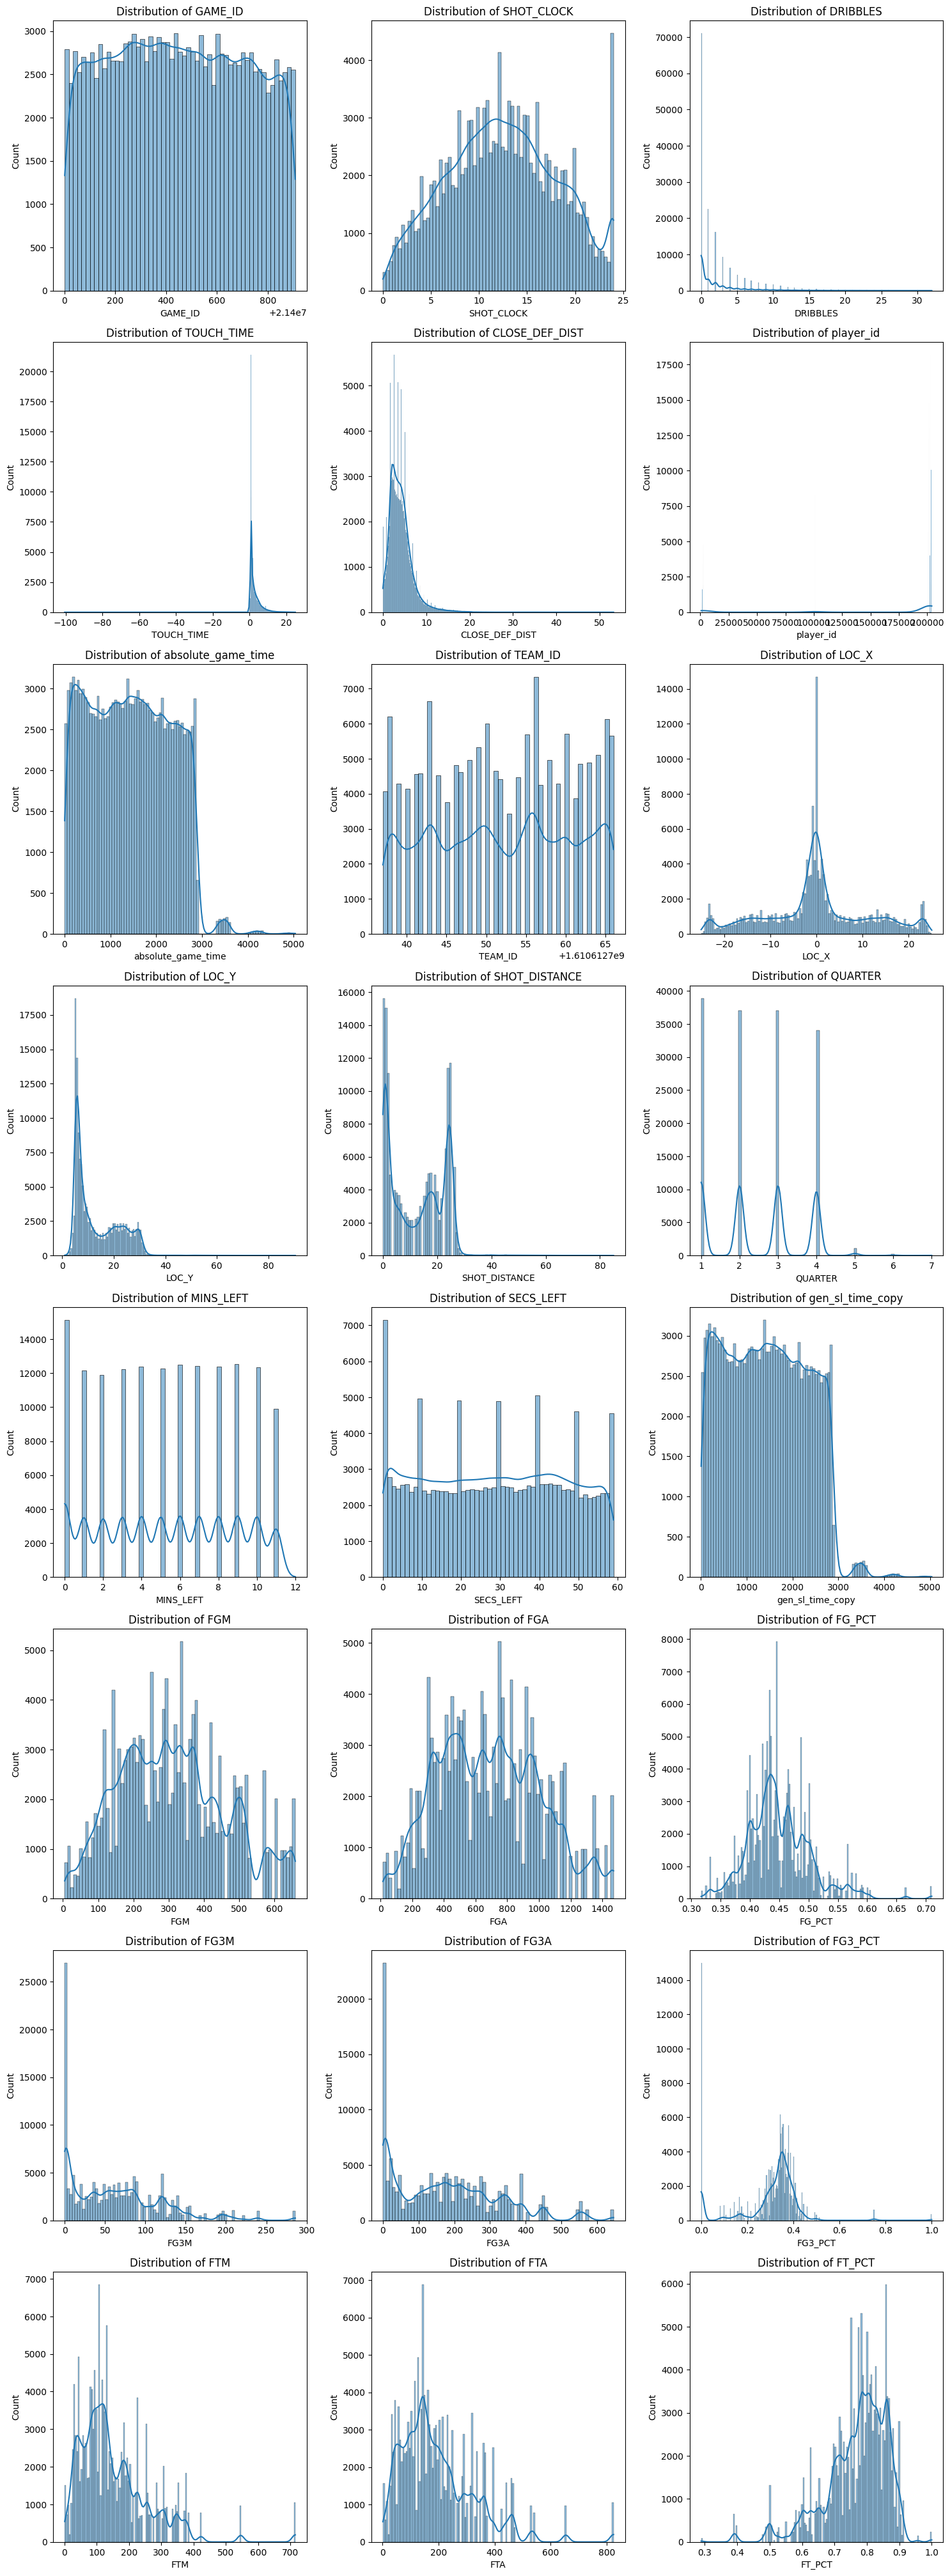

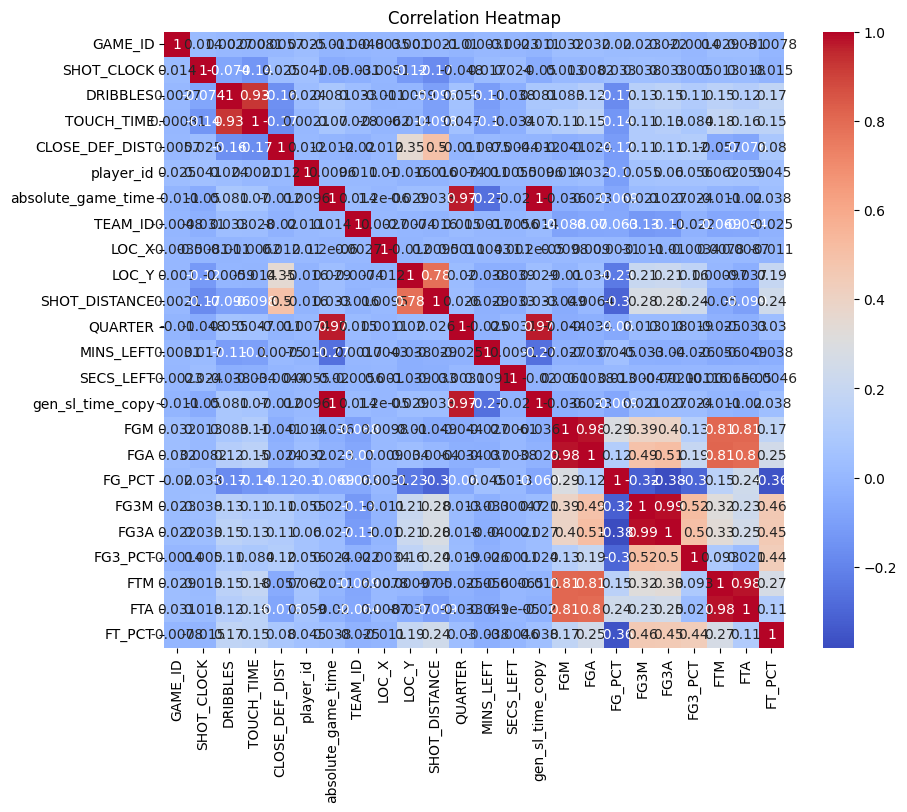

In [60]:
visualize_distributions(for_pred)

In [61]:
importlib.reload(du)
missing_summary = du.missing_values_summary(for_pred)
print(missing_summary)

                 Missing Values  Percentage
HEIGHT_defender          147763   99.686967
SHOT_CLOCK                 6320    4.263731
HEIGHT_attacker             192    0.129531


In [62]:
# check for duplicate rows in the data for prediction
duplicate_rows = for_pred[for_pred.duplicated()]

# display the duplicate rows
print(duplicate_rows)

         GAME_ID  SHOT_CLOCK  DRIBBLES  TOUCH_TIME        CLOSEST_DEFENDER  \
2178    21400759        24.0         0         0.0          Anderson, Alan   
8009    21400587        24.0         0         0.0             West, David   
23516   21400620        22.5         0         0.0             Gibson, Taj   
72122   21400201        10.0         0         0.0          Morris, Marcus   
95878   21400086        24.0         0         0.0        Sullinger, Jared   
114002  21400019         8.5         0         1.0      Jefferson, Richard   
114316  21400834        21.5         2         2.5            Lopez, Brook   
120840  21400409        11.6         3         5.7            Green, Erick   
120841  21400409        11.6         3         5.7            Green, Erick   
120842  21400409        11.6         3         5.7            Green, Erick   
123677  21400276        12.0         2         3.3             Smith, J.R.   
125510  21400276        17.0         0         0.9             S

In [63]:
importlib.reload(du)
constant_columns = du.find_constant_columns(for_pred)
print("Columns with constant values:", constant_columns)

Columns with constant values: ['SEASON_1', 'SEASON_2', 'HEIGHT_defender']


In [64]:
# IMPLEMENT - DROP THE CONSTANT COLS, DEFINITELY SEASON_1

In [65]:
for_pred

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,HEIGHT_defender,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
0,21400468,22.0,2,1.8,"Joseph, Cory",202709,2.3,2754,3.0,2015.0,...,NaN,225,455,0.495,10,29,0.345,79,126,0.627
1,21400818,21.8,3,3.2,"Rose, Derrick",201565,5.3,202693,4.0,2015.0,...,NaN,512,1100,0.465,57,179,0.318,177,232,0.763
2,21400855,20.6,0,0.0,"Ibaka, Serge",201586,4.0,202693,4.0,2015.0,...,NaN,512,1100,0.465,57,179,0.318,177,232,0.763
3,21400292,21.1,0,1.3,"Fournier, Evan",203095,3.4,203463,4.0,2015.0,...,NaN,363,831,0.437,140,391,0.358,130,160,0.813
4,21400892,22.5,2,2.5,"Carroll, DeMarre",201960,3.5,2772,4.0,2015.0,...,NaN,366,910,0.402,194,555,0.350,122,143,0.853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148222,21400375,6.3,17,17.7,"Duncan, Tim",1495,5.0,201144,5017.0,2015.0,...,NaN,393,882,0.446,107,277,0.386,214,249,0.859
148223,21400375,0.7,1,2.1,"Duncan, Tim",1495,9.8,201584,5023.0,2015.0,...,NaN,288,643,0.448,90,224,0.402,111,129,0.860
148224,21400164,NaN,0,0.8,"Antetokounmpo, Giannis",203507,3.9,2207,5030.0,2015.0,...,NaN,446,1025,0.435,121,337,0.359,141,176,0.801
148225,21400375,NaN,9,6.4,"Gasol, Marc",201188,5.1,1938,5035.0,2015.0,...,NaN,251,589,0.426,89,258,0.345,147,204,0.721


In [66]:
target_column = 'SHOT_MADE'

In [67]:
X = for_pred.drop(target_column, axis=1)
y = for_pred[target_column]

In [68]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [69]:
# Handle missing values

num_imputer = SimpleImputer(strategy='mean')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

In [70]:
# Categorical imputer for missing values
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

In [71]:
encoders = {}
for col in categorical_cols:
    encoders[col] = LabelEncoder()
    X[col] = encoders[col].fit_transform(X[col])

In [72]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols]) # zero mean and unit variance for the numerical columns

In [73]:
X

,GAME_ID,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,player_id,absolute_game_time,SEASON_1,...,HEIGHT_defender,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT
0,0.071704,1.698113e+00,-0.038701,-0.341942,242,0.552980,-0.658705,-1.993042,-1.678438,0.0,...,0,-0.562229,-0.715257,0.866139,-0.952083,-1.026384,0.330849,-0.663410,-0.516570,-1.521549
1,1.427895,1.662530e+00,0.239865,0.116474,375,0.538445,0.435024,0.555566,-1.677262,0.0,...,0,1.315080,1.266493,0.299608,-0.120638,-0.004530,0.118783,0.234302,0.280244,-0.080601
2,1.571264,1.449034e+00,-0.595831,-0.931333,213,0.538712,-0.038925,0.555566,-1.677262,0.0,...,0,1.315080,1.266493,0.299608,-0.120638,-0.004530,0.118783,0.234302,0.280244,-0.080601
3,-0.610266,1.537991e+00,-0.595831,-0.505662,145,0.557884,-0.257671,0.565381,-1.677262,0.0,...,0,0.340449,0.439995,-0.229155,1.347658,1.439690,0.432955,-0.196234,-0.260988,0.449159
4,1.714633,1.787070e+00,-0.038701,-0.112734,77,0.543463,-0.221213,-1.992812,-1.677262,0.0,...,0,0.360073,0.682721,-0.890109,2.302935,2.556917,0.370121,-0.269516,-0.388779,0.872967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148222,-0.288655,-1.095126e+00,4.139778,4.864353,127,-2.003498,0.325651,0.535821,4.218002,0.0,...,0,0.536684,0.596692,-0.059196,0.763878,0.663081,0.652876,0.573234,0.408034,0.936539
148223,-0.288655,-2.091441e+00,-0.317266,-0.243710,127,-2.003498,2.075616,0.541429,4.225058,0.0,...,0,-0.150137,-0.137631,-0.021427,0.463142,0.302026,0.778545,-0.370280,-0.494018,0.947134
148224,-1.106245,-6.320751e-16,-0.595831,-0.669381,17,0.563118,-0.075383,-2.000014,4.233290,0.0,...,0,0.883364,1.036057,-0.266924,1.011542,1.071823,0.440809,-0.095470,-0.140714,0.322017
148225,-0.288655,-6.320751e-16,1.911256,1.164282,155,0.533655,0.362108,-2.003443,4.239170,0.0,...,0,-0.392159,-0.303545,-0.436883,0.445452,0.533647,0.330849,-0.040508,0.069765,-0.525600


In [76]:
importlib.reload(du)
X_train, X_val, X_test, y_train, y_val, y_test = du.split_dataset(X, y, test_size=0.1, validation_size=0.2, random_state=2312)

In [44]:
bnk_pbp = playbyplayv3.PlayByPlayV3(game_id='0021400890').get_data_frames()[0]
bnk_pbp['ABS_TIME'] = bnk_pbp.apply(lambda row: du.clock_to_absolute_seconds(row['clock'], row['period']), axis=1)

In [45]:
bnk_pbp_shots = bnk_pbp[bnk_pbp.actionType.str.contains('shot', case=False)].reset_index(drop=True)


In [46]:
bnk_pbp_shots

,gameId,actionNumber,clock,period,teamId,teamTricode,personId,playerName,playerNameI,xLegacy,...,scoreAway,pointsTotal,location,description,actionType,subType,videoAvailable,shotValue,actionId,ABS_TIME
0,0021400890,2,PT11M44.00S,1,1610612747,LAL,201961,Ellington,W. Ellington,234,...,3,3,v,Ellington 24' 3PT Jump Shot (3 PTS) (Kelly 1 AST),Made Shot,Jump Shot,1,0,3,16.0
1,0021400890,3,PT11M29.00S,1,1610612766,CHA,201945,Henderson,G. Henderson,125,...,,0,h,MISS Henderson 18' Jump Shot,Missed Shot,Jump Shot,1,0,4,31.0
2,0021400890,5,PT11M14.00S,1,1610612747,LAL,203135,Sacre,R. Sacre,34,...,5,5,v,Sacre 17' Jump Shot (2 PTS) (Kelly 2 AST),Made Shot,Jump Shot,1,0,6,46.0
3,0021400890,6,PT10M56.00S,1,1610612766,CHA,2590,Williams,M. Williams,-163,...,,0,h,MISS Mo. Williams 20' Jump Shot,Missed Shot,Jump Shot,1,0,7,64.0
4,0021400890,8,PT10M43.00S,1,1610612747,LAL,203903,Clarkson,J. Clarkson,193,...,,0,v,MISS Clarkson 26' 3PT Jump Shot,Missed Shot,Jump Shot,1,0,9,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0021400890,476,PT00M31.90S,4,1610612766,CHA,201945,Henderson,G. Henderson,-142,...,,0,h,MISS Henderson 17' Jump Shot,Missed Shot,Jump Shot,1,0,428,2848.1
161,0021400890,478,PT00M22.80S,4,1610612747,LAL,201941,Hill,J. Hill,56,...,,0,v,MISS Hill 19' Jump Shot,Missed Shot,Jump Shot,1,0,430,2857.2
162,0021400890,510,PT00M09.00S,4,1610612747,LAL,203903,Clarkson,J. Clarkson,-2,...,98,199,v,Clarkson 1' Driving Layup (19 PTS) (Hill 2 AST),Made Shot,Driving Layup Shot,1,0,451,2871.0
163,0021400890,525,PT00M04.80S,4,1610612747,LAL,201941,Hill,J. Hill,7,...,100,203,v,Hill 1' Layup (10 PTS) (Johnson 3 AST),Made Shot,Layup Shot,1,0,460,2875.2


In [69]:
gen_sl_abs_times = set(game_gen_sl['ABS_TIME'].unique())
pbp_times = set(bnk_pbp_shots['ABS_TIME'].unique())

common_game_ids = gen_sl_abs_times.intersection(pbp_times)

print(f"Number of unique in gen_sl: {len(gen_sl_abs_times)}")
print(f"Number of unique in pbp: {len(pbp_times)}")
print(f"Number of common in both: {len(common_game_ids)}")

Number of unique in gen_sl: 100
Number of unique in pbp: 165
Number of common in both: 93


In [265]:
ap_1415_index = playerindex.PlayerIndex(season='2014-15').get_data_frames()[0]

In [267]:
ap_1415_index.columns

Index(['PERSON_ID', 'PLAYER_LAST_NAME', 'PLAYER_FIRST_NAME', 'PLAYER_SLUG',
       'TEAM_ID', 'TEAM_SLUG', 'IS_DEFUNCT', 'TEAM_CITY', 'TEAM_NAME',
       'TEAM_ABBREVIATION', 'JERSEY_NUMBER', 'POSITION', 'HEIGHT', 'WEIGHT',
       'COLLEGE', 'COUNTRY', 'DRAFT_YEAR', 'DRAFT_ROUND', 'DRAFT_NUMBER',
       'ROSTER_STATUS', 'FROM_YEAR', 'TO_YEAR', 'PTS', 'REB', 'AST',
       'STATS_TIMEFRAME'],
      dtype='object')

In [ ]:
ap_1415_index_for_join = ap_1415_index[['PERSON_ID', 'HEIGHT']]